In [10]:
import os

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

from astropy.modeling.models import BlackBody
from astropy import units as u

from astropy.visualization import quantity_support
quantity_support()

from specutils import Spectrum1D, SpectralRegion

DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data/Szkody APO Spectra"
os.listdir(DATA_DIR)

['f24s.fits', 'f23s.fits']

In [8]:
USE_SINGLE_SPECTRUM = False
spec: Spectrum1D = None

if USE_SINGLE_SPECTRUM:
	print("Single spectrum")
	fitsPath = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])
	spec = Spectrum1D.read(fitsPath)
else:
	print("Using spectra average")
	for f in os.listdir(DATA_DIR):
		s = Spectrum1D.read(os.path.join(DATA_DIR, f))
		if spec is None:
			spec = s
		else:
			spec += s

	spec /= len(os.listdir(DATA_DIR))

Using spectra average


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


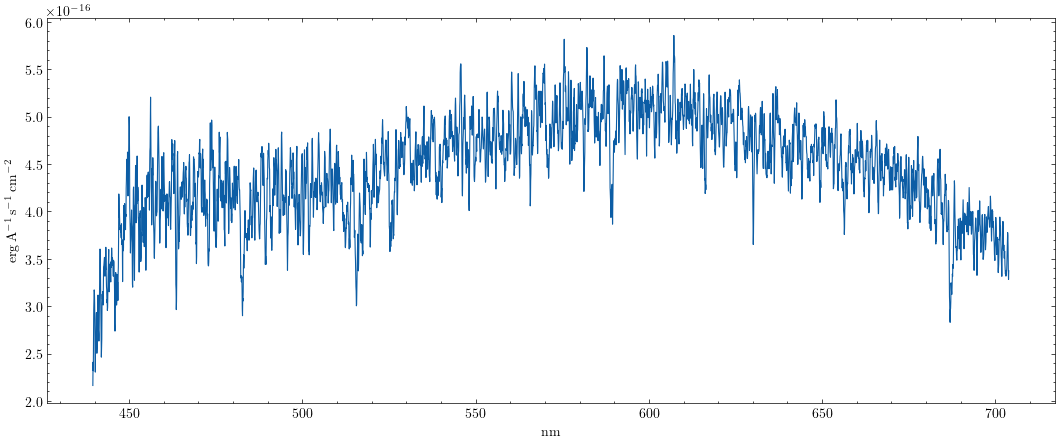

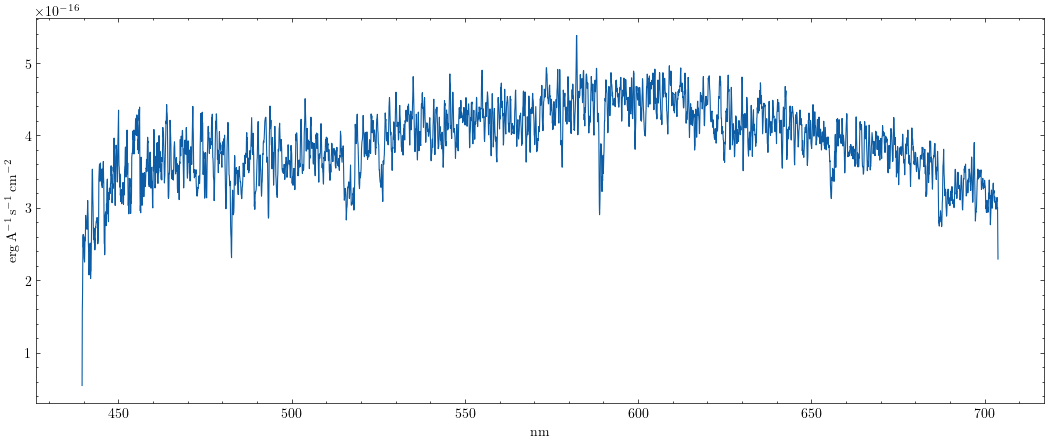

In [12]:
for f in os.listdir(DATA_DIR):
	s = Spectrum1D.read(os.path.join(DATA_DIR, f))
	plt.figure(figsize=(13, 5))
	plt.plot(s.spectral_axis.to(u.nm), s.flux, linewidth=0.8)

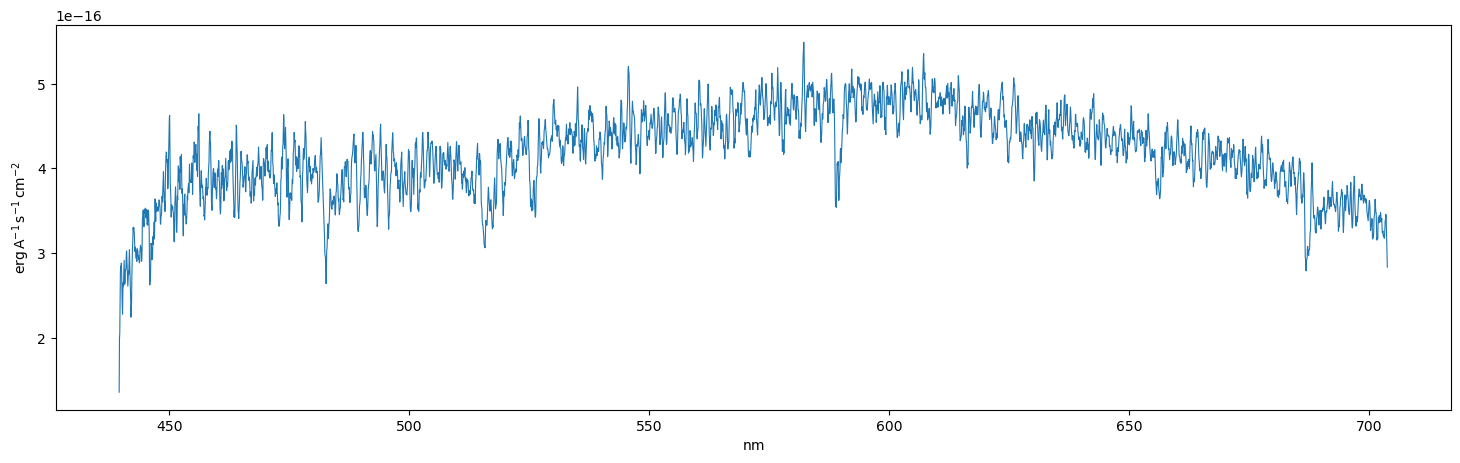

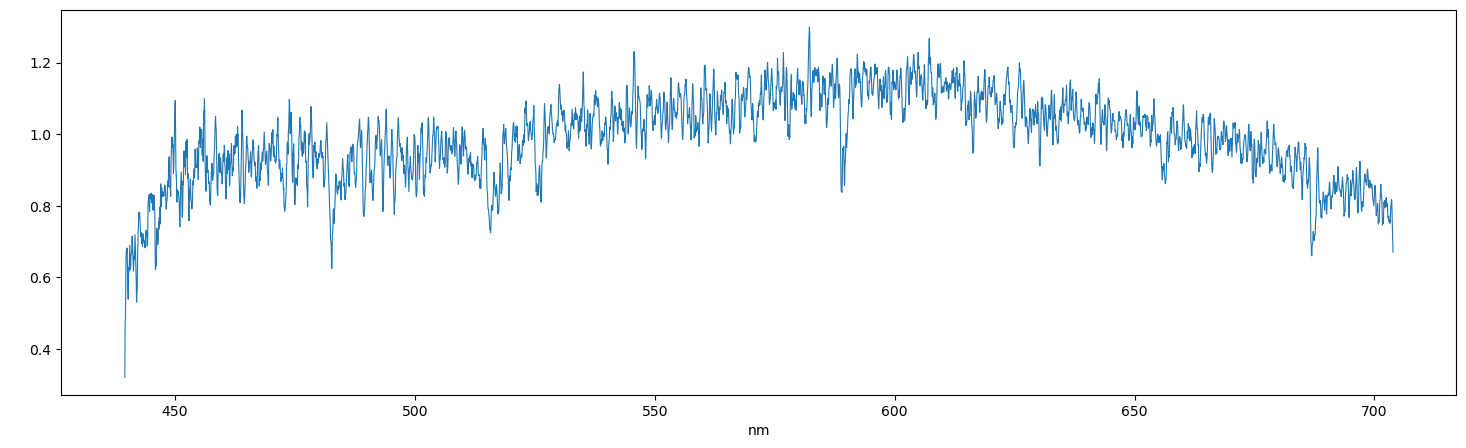

In [9]:
plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis.to(u.nm), spec.flux, linewidth=0.8)

plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis.to(u.nm), spec.flux / np.median(spec.flux), linewidth=0.8)

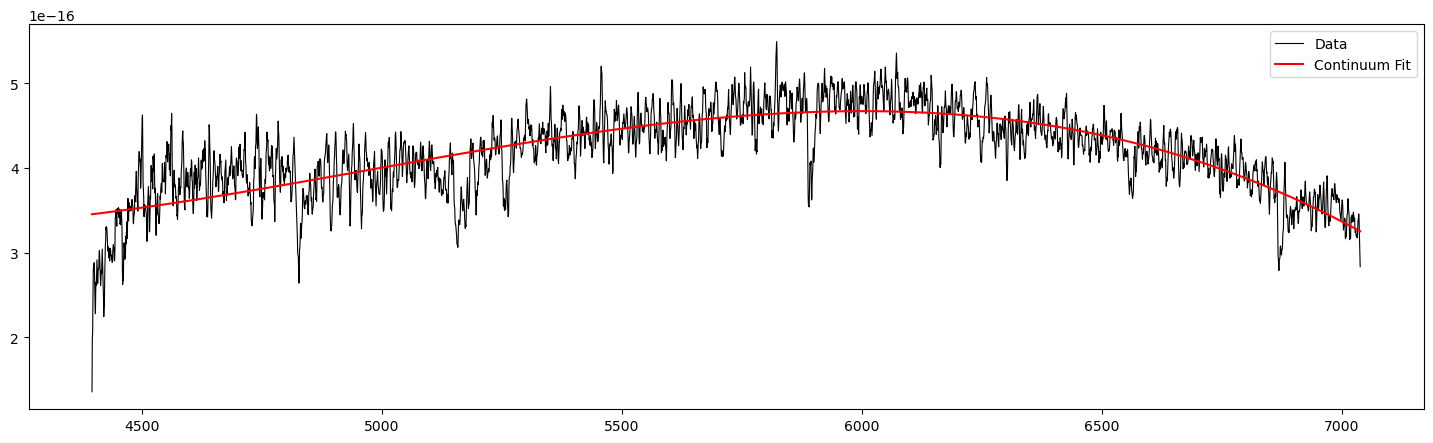

In [28]:
from specutils.fitting import fit_generic_continuum

generif_fit = fit_generic_continuum(spec)
specContinuum = generif_fit(spec.spectral_axis)

plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis, spec.flux, linewidth=0.8, label='Data', color='black')
plt.plot(spec.spectral_axis, specContinuum, label='Continuum Fit', color='red')
plt.legend()

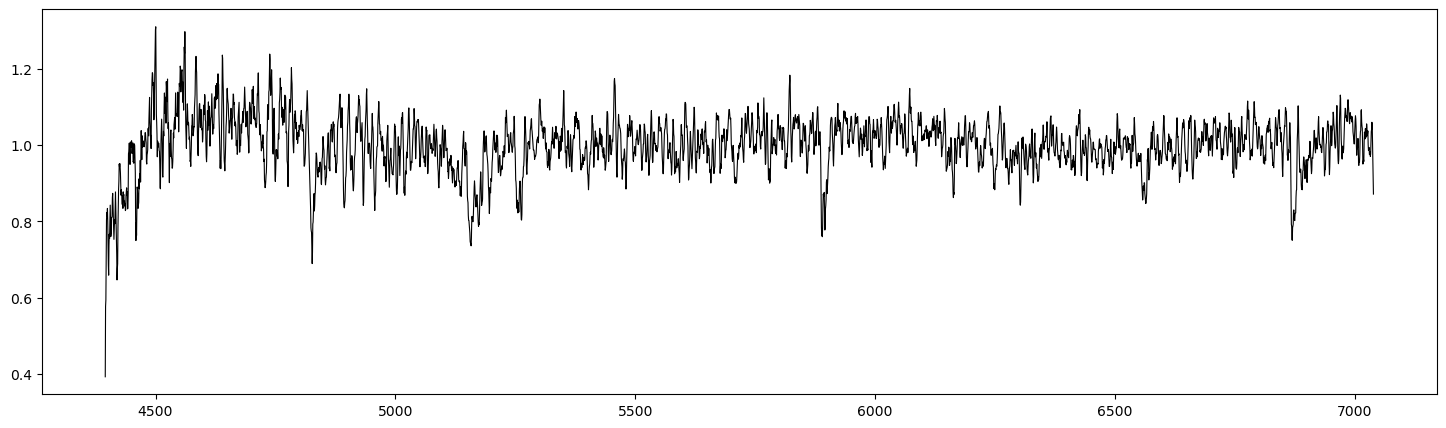

In [8]:
spec_norm = spec / specContinuum

plt.figure(figsize=(18, 5))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

Spectrum1D (length=4095)
flux:             [ 0.39278, ..., 0.87132 ],  mean=1.0
spectral axis:    [ 4395.2 Angstrom, ..., 7038.7 Angstrom ],  mean=5716.9 Angstrom
uncertainty:      [ StdDevUncertainty(0.04756255), ..., StdDevUncertainty(0.04756255) ]



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4399.688417280887,emission,7
4416.476745664383,emission,33
4500.418387581862,emission,163
5822.176395313241,emission,2210


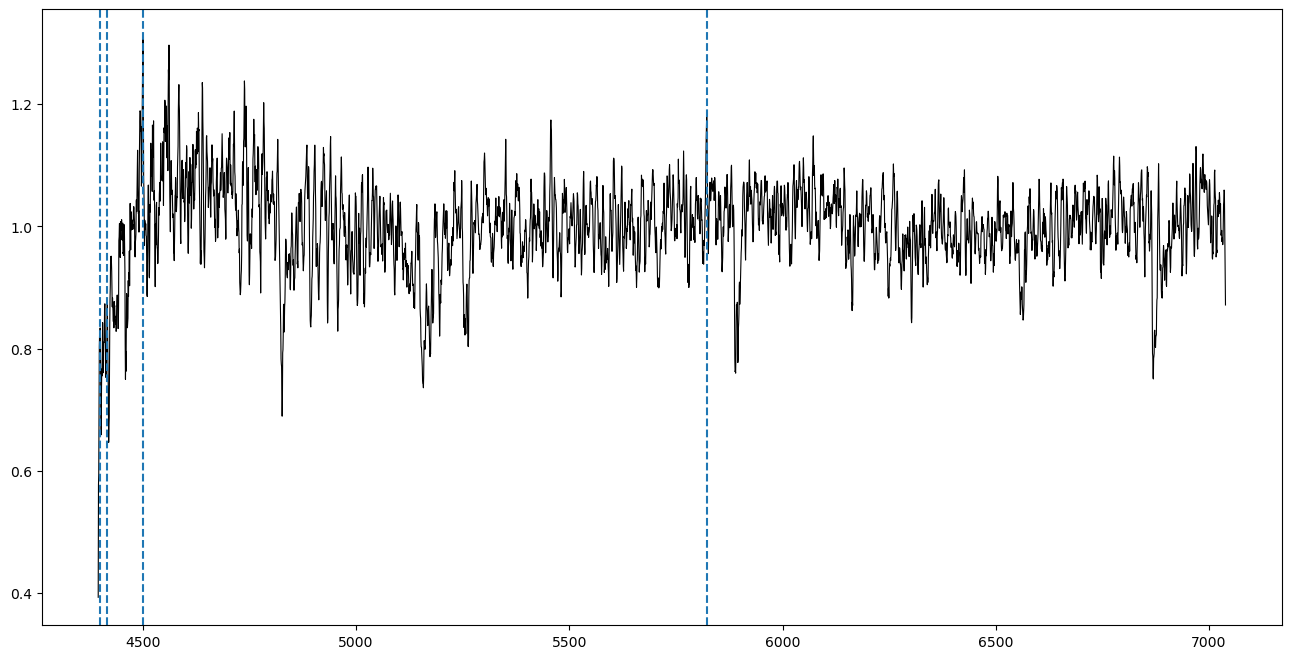

In [24]:
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold, find_lines_derivative

noise_region = SpectralRegion(5500*u.AA, 5800*u.AA)
spectrumNoise = noise_region_uncertainty(spec_norm, noise_region)
print(spectrumNoise)

lines = find_lines_threshold(spectrumNoise, noise_factor=15)  
# lines = find_lines_derivative(spec_norm, flux_threshold=1.1)

plt.figure(figsize=(16, 8))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

for row in lines:
	plt.axvline(row['line_center'].value, linestyle='dashed')
lines

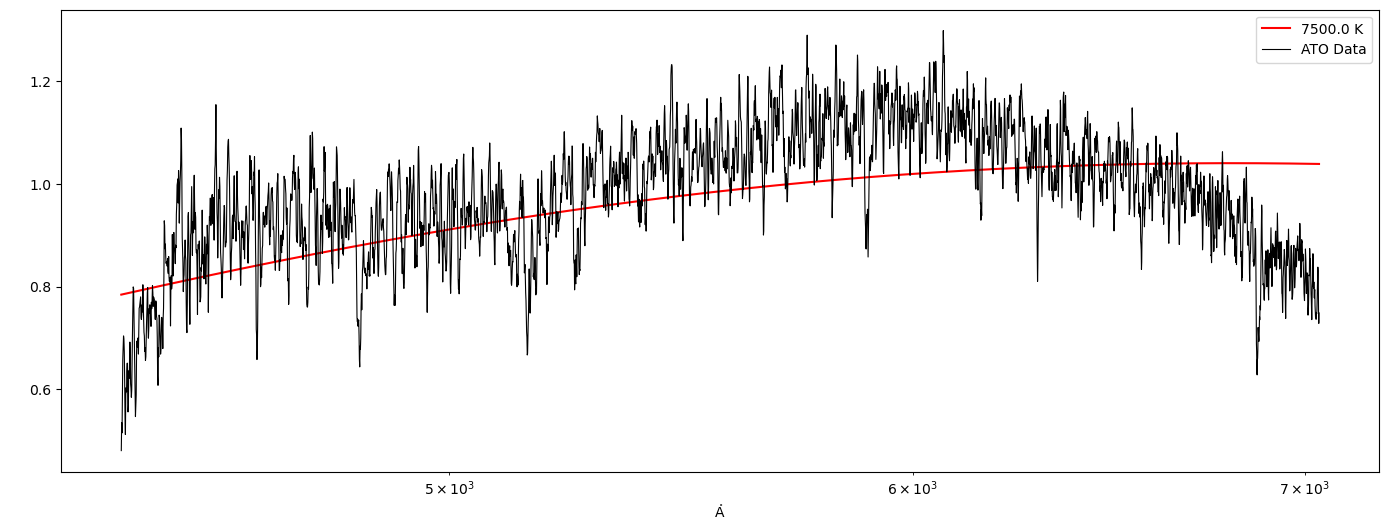

In [49]:
temperature = 7500*u.K
bb = BlackBody(temperature=temperature)
flux = bb(spec.spectral_axis)

with quantity_support():
    plt.figure(figsize=(17, 6))
    plt.semilogx(spec.spectral_axis, flux / np.median(flux), label=temperature, color='red')
    plt.semilogx(spec.spectral_axis, spec.flux / np.median(spec.flux), label='ATO Data',color='black', lw=0.8)
    plt.legend()
    plt.show()